<a href="https://colab.research.google.com/github/jenvieve/OCR-grad-project/blob/main/OCR_AI_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!apt-get install poppler-utils > /dev/null
!pip install pytesseract pillow pdf2image textblob ipywidgets googletrans > /dev/null

In [15]:
import pytesseract
from PIL import Image
from pdf2image import convert_from_path
from textblob import TextBlob
import ipywidgets as widgets
from IPython.display import display
from googletrans import Translator
from transformers import pipeline

In [3]:
from google.colab import files

print("This is an OCR tool that can help extract text from a document.")
print("Please upload one or more Image or PDF files you'd like to process:")
uploaded = files.upload()

This is an OCR tool that can help extract text from a document.
Please upload one or more Image or PDF files you'd like to process:


Saving 2.png to 2.png


In [4]:
ocr_type = input("Is the text printed or handwritten? (type 'printed' or 'handwritten'): ").strip().lower()

if ocr_type not in ["printed", "handwritten"]:
    print("Invalid input. Defaulting to printed.")
    ocr_type = "printed"

if ocr_type == "handwritten":
    print("Note: Handwriting recognition may be less accurate. It is recommended to enable spell correction at the end.")

Is the text printed or handwritten? (type 'printed' or 'handwritten'): printed


In [5]:
def extract_printed_text(file_name):
    text = ""
    if file_name.lower().endswith(".pdf"):
        pages = convert_from_path(file_name, dpi=300)
        for i, page in enumerate(pages, start=1):
            print(f"Page {i}")
            display(page)
            text += f"--- {file_name} (Page {i}) ---\n"
            text += pytesseract.image_to_string(page) + "\n\n"
    else:
        image = Image.open(file_name).convert("RGB")
        print(f"Image: {file_name}")
        display(image)
        text += f"--- {file_name} ---\n"
        text += pytesseract.image_to_string(image) + "\n\n"
    return text

def extract_handwritten_text(file_name):
    text = ""

    def to_grayscale(image_path):
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return Image.fromarray(gray)

    if file_name.lower().endswith(".pdf"):
        pages = convert_from_path(file_name, dpi=300)
        for i, page in enumerate(pages, start=1):
            temp_path = f"temp_handwritten_{i}.png"
            page.save(temp_path, "PNG")
            gray_image = to_grayscale(temp_path)
            print(f"Page {i}")
            display(gray_image)
            page_text = pytesseract.image_to_string(gray_image, config='--psm 6')
            text += f"--- {file_name} (Page {i}) ---\n"
            text += page_text + "\n\n"
    else:
        gray_image = to_grayscale(file_name)
        print(f"Image: {file_name}")
        display(gray_image)
        image_text = pytesseract.image_to_string(gray_image, config='--psm 6')
        text += f"--- {file_name} ---\n"
        text += image_text + "\n\n"

    return text


 Processing: 2.png
Image: 2.png


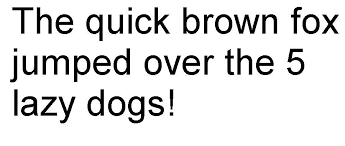

Recognized Text:
--- 2.png ---
The quick brown fox
jumped over the 5
lazy dogs!





In [6]:
extracted_text = ""

for file_name in uploaded.keys():
    print(f"\n Processing: {file_name}")

    if ocr_type == "handwritten":
        result = extract_handwritten_text(file_name)
    else:
        result = extract_printed_text(file_name)

    print("Recognized Text:")
    if result.strip():
        print(result)
    else:
        print("No readable text found in this file.")

    extracted_text += result

In [7]:
spell_correct_option = input("Would you like to apply spell correction to the extracted text? (yes/no): ").strip().lower()

def correct_text(text):
    blob = TextBlob(text)
    return str(blob.correct())

if spell_correct_option == "yes":
    corrected_text = correct_text(extracted_text)
    print("\n Spell correction applied!")
    print("\n Corrected Text:")
    print(corrected_text)
else:
    corrected_text = extracted_text
    print("\n Spell correction skipped.")

Would you like to apply spell correction to the extracted text? (yes/no): yes

 Spell correction applied!

 Corrected Text:
--- 2.pig ---
The quick brown fox
jumped over the 5
lazy dogs!





In [8]:
def manual_edit_text():
    global extracted_text
    print("\n You can edit the extracted text below. After editing, click Confirm Changes.")

    text_area = widgets.Textarea(
        value=extracted_text,
        placeholder='Edit your text here...',
        description='',
        disabled=False,
        layout=widgets.Layout(width='100%', height='300px')
    )

    confirm_button = widgets.Button(description="Confirm Changes", button_style='success')
    output = widgets.Output()

    def on_confirm_clicked(b):
        global extracted_text
        with output:
            extracted_text = text_area.value
            print("\n Updated Text Saved Successfully!")

    confirm_button.on_click(on_confirm_clicked)
    display(text_area, confirm_button, output)

manual_edit = input("Do you want to manually edit the text? (yes/no): ").strip().lower()

if manual_edit == 'yes':
    manual_edit_text()
    while True:
        proceed = input("\n After confirming, type 'done' to continue: ").strip().lower()
        if proceed == 'done':
            break
        else:
            print(" Waiting... Type 'done' once you confirm.")

Do you want to manually edit the text? (yes/no): yes

 You can edit the extracted text below. After editing, click Confirm Changes.


Textarea(value='--- 2.png ---\nThe quick brown fox\njumped over the 5\nlazy dogs!\n\x0c\n\n', layout=Layout(he…

Button(button_style='success', description='Confirm Changes', style=ButtonStyle())

Output()


 After confirming, type 'done' to continue: done


In [16]:
# Menu
def display_menu():
    print("\n Is there anything else you'd like to do? Please choose an action:")
    print("1. Summarize the Text")
    print("2. Search the Number of Occurrence of a Word")
    print("3. Count Number of Words")
    print("4. Translate the Text")
    print("5. Nothing, Exit")

    choice = input("Enter the number of your choice: ")
    return choice

# Function to summarize the text
def summarize_text(extracted_text):
    summarizer = pipeline("summarization")
    summary = summarizer(extracted_text, max_length=150, min_length=5, do_sample=False)
    return summary[0]['summary_text']

# Function to count the number of words in the text
def count_words(extracted_text):
    words = extracted_text.split()
    return len(words)

# Function to translate the text
def translate_text(extracted_text):
    translator = Translator()
    detected = translator.detect(extracted_text)
    src_lang = detected.lang
    print("Detected language:", src_lang)
    target_lang = input("Enter target language code (codes can be found in this link: https://developers.google.com/workspace/admin/directory/v1/languages): ").strip().lower()
    translated = translator.translate(extracted_text, src=src_lang, dest=target_lang)
    return translated.text

# Function to search how many times a word appeared in the text
def search_word(extracted_text, word):
    occurrences = extracted_text.lower().count(word.lower())
    return occurrences

In [17]:
# Main function
def process_text(extracted_text):
    final_text = extracted_text

    while True:
        choice = display_menu()

        if choice == '1':
            # Summarize the text
            summary = summarize_text(extracted_text)
            print("\nSummary:\n", summary)
            final_text += "\n\n--- Summary ---\n" + summary
            final_text += "\n" + "-"*40 + "\n"

        elif choice == '2':
            # Search how many times a word appeared
            word = input("Enter the word you want to search for: ")
            occurrences = search_word(extracted_text, word)
            print(f"'{word}' found {occurrences} time(s) in the text.")
            final_text += f"\n\n--- Word Search Result ---\n'{word}' found {occurrences} time(s) in the text."
            final_text += "\n" + "-"*40 + "\n"

        elif choice == '3':
            # Count the number of words
            word_count = count_words(extracted_text)
            print(f"Total number of words: {word_count}")
            final_text += f"\n\n--- Word Count ---\nTotal number of words: {word_count}"
            final_text += "\n" + "-"*40 + "\n"

        elif choice == '4':
            # Translate the text
            translation = translate_text(extracted_text)
            print("\nTranslated Text:\n", translation)
            final_text += "\n\n--- Translated Text ---\n" + translation
            final_text += "\n" + "-"*40 + "\n"

        elif choice == '5':
            # Exit the loop
            print("No action selected. Exiting...\n")
            break

        else:
            print("Invalid choice. Please select a valid option.")

    return final_text

# To call the function
final_text = process_text(extracted_text)


 Is there anything else you'd like to do? Please choose an action:
1. Summarize the Text
2. Search the Number of Occurrence of a Word
3. Count Number of Words
4. Translate the Text
5. Nothing, Exit
Enter the number of your choice: 1


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu
Your max_length is set to 150, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)



Summary:
  The quick brown foxjumped over the  lazy dogs! The fox jumped over the lazy dogs!

 Is there anything else you'd like to do? Please choose an action:
1. Summarize the Text
2. Search the Number of Occurrence of a Word
3. Count Number of Words
4. Translate the Text
5. Nothing, Exit
Enter the number of your choice: 5
No action selected. Exiting...



In [18]:
# Function for extracted text only
def preview_and_save_extracted_text(extracted_text):
    print("\nPreview of the Extracted Text to be Saved:")
    print("\n" + "="*50)

    # Show preview
    print("----- Extracted Text -----")
    print(extracted_text)
    print("="*50)

    # Ask for confirmation before saving
    confirm = input("\n Confirm? (yes/no): ").strip().lower()
    if confirm == 'yes':
        save_extracted_text_only(extracted_text)
    else:
        print("No content was saved.")

# Function for the entire result (extracted text + menu modifications)
def preview_and_save_full_output(extracted_text, final_text):
    print("\nPreview of the Full Output to be Saved:")
    print("\n" + "="*50)

    # Show preview
    print("----- Final Output -----")
    print(final_text)
    print("="*50)

    # Ask for confirmation before saving
    confirm = input("\n Confirm? (yes/no): ").strip().lower()
    if confirm == 'yes':
        save_full_output(final_text)
    else:
        print("No content was saved.")

# Function to save the extracted text only
def save_extracted_text_only(extracted_text, filename="extracted_text_only.txt"):
    with open(filename, 'w') as file:
        file.write("----- Extracted Text -----\n")
        file.write(extracted_text)
        file.write("\n\n")
    print(f"Extracted text saved to {filename}")

# Function to save the entire result
def save_full_output(final_text, filename="final_output.txt"):
    with open(filename, 'w') as file:
        file.write("----- Full Output -----\n")
        file.write(final_text)
        file.write("\n\n")
    print(f"Full output saved to {filename}")

# Main function
def save_output(extracted_text, final_text):
    save_choice = input("\nWould you like to save the output? (yes/no): ").strip().lower()

    if save_choice == 'yes':
        save_type = input("\nDo you want to save only the extracted text or the full result (with actions done in the menu)? (extracted/full): ").strip().lower()

        if save_type == "extracted":
            preview_and_save_extracted_text(extracted_text)
        elif save_type == "full":
            preview_and_save_full_output(extracted_text, final_text)
        else:
            print("Invalid option. No content saved.")
    else:
        print("You chose not to save the text.")

save_output(extracted_text, final_text)


Would you like to save the output? (yes/no): no
You chose not to save the text.
